In [35]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
from matplotlib.animation import PillowWriter
import scienceplots

plt.style.use(["science", "notebook"])
from itertools import combinations

Define number of particles and get random positions (between 0 and 1) for each particle

In [36]:
n_particles = 100
r = np.random.random((2, n_particles))
# Color particles the start on either side
ixr = r[0] > 0.5  # right
ixl = r[0] <= 0.5  # left

Give IDs to each particle (this will come in handy later)

In [37]:
ids = np.arange(n_particles)

Plot initial configuration of particles

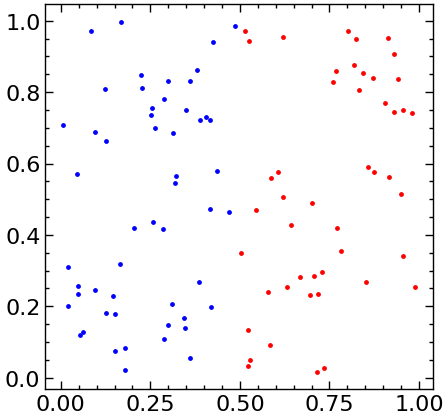

In [38]:
plt.figure(figsize=(5, 5))
plt.scatter(r[0][ixr], r[1][ixr], color="r", s=6)
plt.scatter(r[0][ixl], r[1][ixl], color="b", s=6)

Obtain the initial velocities in the gas. We'll make the particles starting on the RHS move to the left at 500m/s and on the vice versa.

* **Note**: We're using the assumption that particles in a gas move at approximately 500m/s, thanks google.

In [39]:
v = np.zeros((2, n_particles))
v[0][ixr] = -500
v[0][ixl] = 500

To run this simulation, we need to determine when two particles collide, and what the resulting final velocities will be.

# Part 1: Distance Between all Pairs

* To determine if two particles collide, we need to find the distance between **all pairs** of particles. If the distance is less than 2 times the radius of each particle, they collide. If there are $n$ particles, there are $n(n-1)/2$ pairs (combinatorics). To make this easier, we'll get pairs of particle IDs.

In [40]:
ids_pairs = np.asarray(list(combinations(ids, 2)))

We can obtain distances between particles in a similar fashion

* First get the pairs of x-positions of all particles (**NOTE: THIS HAS BEEN UPDATED SINCE THE YOUTUBE VIDEO AND IS MUCH MORE EFFICIENT. THANK YOU TO @swni ON REDDIT FOR THE SUGGESTION**)

In [41]:
x_pairs = np.array([r[0][ids_pairs[:, 0]], r[0][ids_pairs[:, 1]]]).T

* Then take the difference to get $\Delta x_{ij}$ of all pairs

In [42]:
dx_pairs = np.diff(x_pairs, axis=1).ravel()

The total distance is just $d_{ij}= \sqrt{\Delta x_{ij}^2 + \Delta y_{ij}^2}$. Since there are $n(n-1)/2$ pairs, there will be $n(n-1)/2$ different values of $d_{ij}$.

In [43]:
x_pairs = np.array([r[0][ids_pairs[:, 0]], r[0][ids_pairs[:, 1]]]).T
y_pairs = np.array([r[1][ids_pairs[:, 0]], r[1][ids_pairs[:, 1]]]).T
dx_pairs = np.diff(x_pairs, axis=1).ravel()
dy_pairs = np.diff(y_pairs, axis=1).ravel()
d_pairs = np.sqrt(dx_pairs**2 + dy_pairs**2)

# Part 2: Velocities of a Collision

So at each iteration of the simulation, we will evaluate `d_pairs`, and if any of the distances between particles is less than $2r$, then a collision occurs. What is the final velocity of each of the two spheres? In an elastic collision (conservation of energy + momentum + angular momentum), one can show

$$\vec{v}_1^{\text{new}} = \vec{v}_1 - \frac{(\vec{v}_1 - \vec{v}_2) \cdot (\vec{r}_1 - \vec{r}_2)}{|\vec{r}_1 - \vec{r}_2|^2} (\vec{r}_1 - \vec{r}_2)$$
$$\vec{v}_2^{\text{new}} = \vec{v}_2 - \frac{(\vec{v}_2 - \vec{v}_1) \cdot (\vec{r}_2 - \vec{r}_1)}{|\vec{r}_1 - \vec{r}_2|^2} (\vec{r}_2 - \vec{r}_1)$$

In [44]:
radius = 0.06
ids_pairs_collide = ids_pairs[d_pairs < 2 * radius]

We will call all the particles in the left column "1" and the right column "2"

In [45]:
v1 = v[:, ids_pairs_collide[:, 0]]
v2 = v[:, ids_pairs_collide[:, 1]]
r1 = r[:, ids_pairs_collide[:, 0]]
r2 = r[:, ids_pairs_collide[:, 1]]

Then we can compute the new velocity:

In [46]:
v1new = v1 - ((v1 - v2) * (r1 - r2)).sum(axis=0) / np.sum((r1 - r2) ** 2, axis=0) * (
    r1 - r2
)
v2new = v2 - ((v1 - v2) * (r1 - r2)).sum(axis=0) / np.sum((r2 - r1) ** 2, axis=0) * (
    r2 - r1
)

# Part 3: Functions to Run the Simulation

Here we define some functions that will help make running the simulation easier.

In [47]:
def get_delta_pairs(x, ids_pairs):
    return np.diff(np.array([x[ids_pairs[:, 0]], x[ids_pairs[:, 1]]]).T, axis=1).ravel()


def get_deltad_pairs(r, ids_pairs):
    return np.sqrt(
        get_delta_pairs(r[0], ids_pairs) ** 2 + get_delta_pairs(r[1], ids_pairs) ** 2
    )


def compute_new_v(v1, v2, r1, r2):
    v1new = v1 - ((v1 - v2) * (r1 - r2)).sum(axis=0) / np.sum(
        (r1 - r2) ** 2, axis=0
    ) * (r1 - r2)
    v2new = v2 - ((v1 - v2) * (r1 - r2)).sum(axis=0) / np.sum(
        (r2 - r1) ** 2, axis=0
    ) * (r2 - r1)
    return v1new, v2new


def motion(r, v, id_pairs, ts, dt, d_cutoff):
    rs = np.zeros((ts, r.shape[0], r.shape[1]))
    vs = np.zeros((ts, v.shape[0], v.shape[1]))
    # Initial State
    rs[0] = r.copy()
    vs[0] = v.copy()
    for i in range(1, ts):
        ic = id_pairs[get_deltad_pairs(r, ids_pairs) < d_cutoff]
        v[:, ic[:, 0]], v[:, ic[:, 1]] = compute_new_v(
            v[:, ic[:, 0]], v[:, ic[:, 1]], r[:, ic[:, 0]], r[:, ic[:, 1]]
        )

        v[0, r[0] > 1] = -np.abs(v[0, r[0] > 1])
        v[0, r[0] < 0] = np.abs(v[0, r[0] < 0])
        v[1, r[1] > 1] = -np.abs(v[1, r[1] > 1])
        v[1, r[1] < 0] = np.abs(v[1, r[1] < 0])

        r = r + v * dt
        rs[i] = r.copy()
        vs[i] = v.copy()
    return rs, vs

Set the radius and find the position of all particles as a function of time (3D array `rs` where each axis is $(t,x,y)$).

In [48]:
radius = 0.03
rs, vs = motion(r, v, ids_pairs, ts=1000, dt=0.000008, d_cutoff=2 * radius)

Plot red and blue circles, making sure each is the correct size.

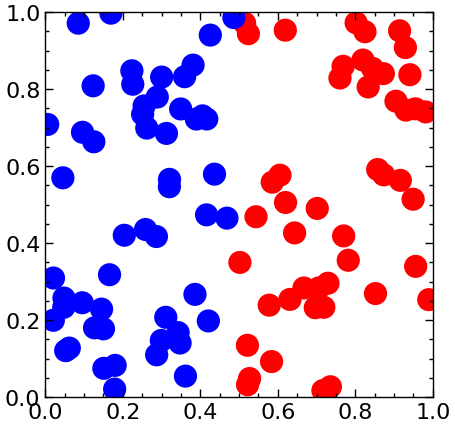

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
xred, yred = rs[0][0][ixr], rs[0][1][ixr]
xblue, yblue = rs[0][0][ixl], rs[0][1][ixl]
circles_red = [
    plt.Circle((xi, yi), radius=radius, linewidth=0) for xi, yi in zip(xred, yred)
]
circles_blue = [
    plt.Circle((xi, yi), radius=radius, linewidth=0) for xi, yi in zip(xblue, yblue)
]
cred = matplotlib.collections.PatchCollection(circles_red, facecolors="red")
cblue = matplotlib.collections.PatchCollection(circles_blue, facecolors="blue")
ax.add_collection(cred)
ax.add_collection(cblue)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plt.show()

Make initial animation of the simulation

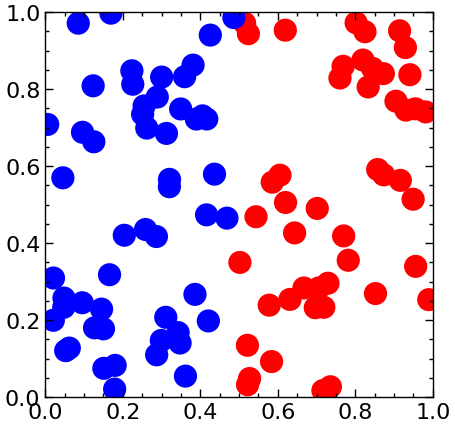

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))


def animate(i):
    ax.clear()
    xred, yred = rs[i][0][ixr], rs[i][1][ixr]
    xblue, yblue = rs[i][0][ixl], rs[i][1][ixl]
    circles_red = [
        plt.Circle((xi, yi), radius=radius, linewidth=0) for xi, yi in zip(xred, yred)
    ]
    circles_blue = [
        plt.Circle((xi, yi), radius=radius, linewidth=0) for xi, yi in zip(xblue, yblue)
    ]
    cred = matplotlib.collections.PatchCollection(circles_red, facecolors="red")
    cblue = matplotlib.collections.PatchCollection(circles_blue, facecolors="blue")
    ax.add_collection(cred)
    ax.add_collection(cblue)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)


ani = animation.FuncAnimation(fig, animate, frames=500, interval=50)
ani.save("ani3.gif", writer="pillow", fps=30, dpi=100)

Now that we're sure that it works, lets make a simulation containing many more particles

In [51]:
n_particles = 5000
r = np.random.random((2, n_particles))
ixr = r[0] > 0.5
ixl = r[0] <= 0.5
ids = np.arange(n_particles)
ids_pairs = np.asarray(list(combinations(ids, 2)))
v = np.zeros((2, n_particles))
v[0][ixr] = -500
v[0][ixl] = 500
radius = 0.0015
rs, vs = motion(r, v, ids_pairs, ts=1000, dt=0.000008, d_cutoff=2 * radius)

Let's look at the final velocity distribution of the particles and compare it to Maxwell-Boltzmann in 2 Dimensions:

* $kT = KE_{avg} = \frac{1}{2}m\bar{v^2} \implies \boxed{\frac{m}{kT} = \frac{2}{\bar{v^2}}}$
* $\boxed{f(v) = \frac{m}{kT} v \exp\left(-\frac{m}{kT}\frac{v^2}{2} \right)}$

In [52]:
v = np.linspace(0, 2000, 1000)
a = 2 / 500**2
fv = a * v * np.exp(-a * v**2 / 2)

Plot the final histogram next to this curve:

Text(0, 0.5, '# Particles')

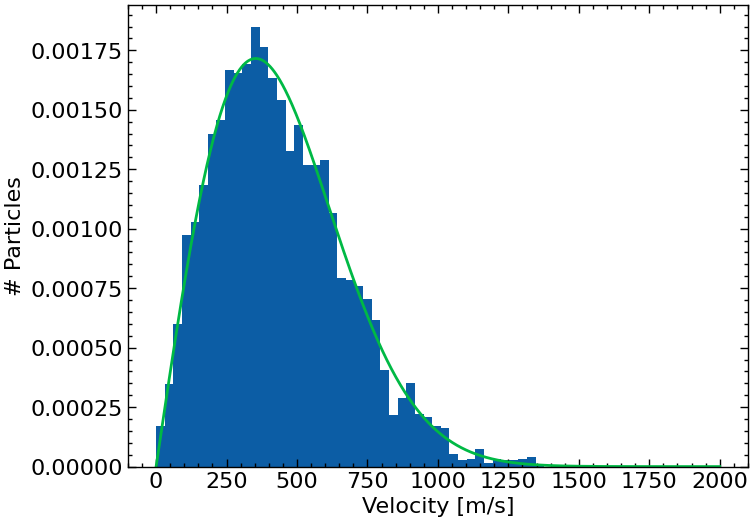

In [53]:
bins = np.linspace(0, 1500, 50)
plt.figure()
plt.hist(np.sqrt(np.sum(vs[400] ** 2, axis=0)), bins=bins, density=True)
plt.plot(v, fv)
plt.xlabel("Velocity [m/s]")
plt.ylabel("# Particles")

Finally, we can make an animation of the particles moving around and the histogram at the same time

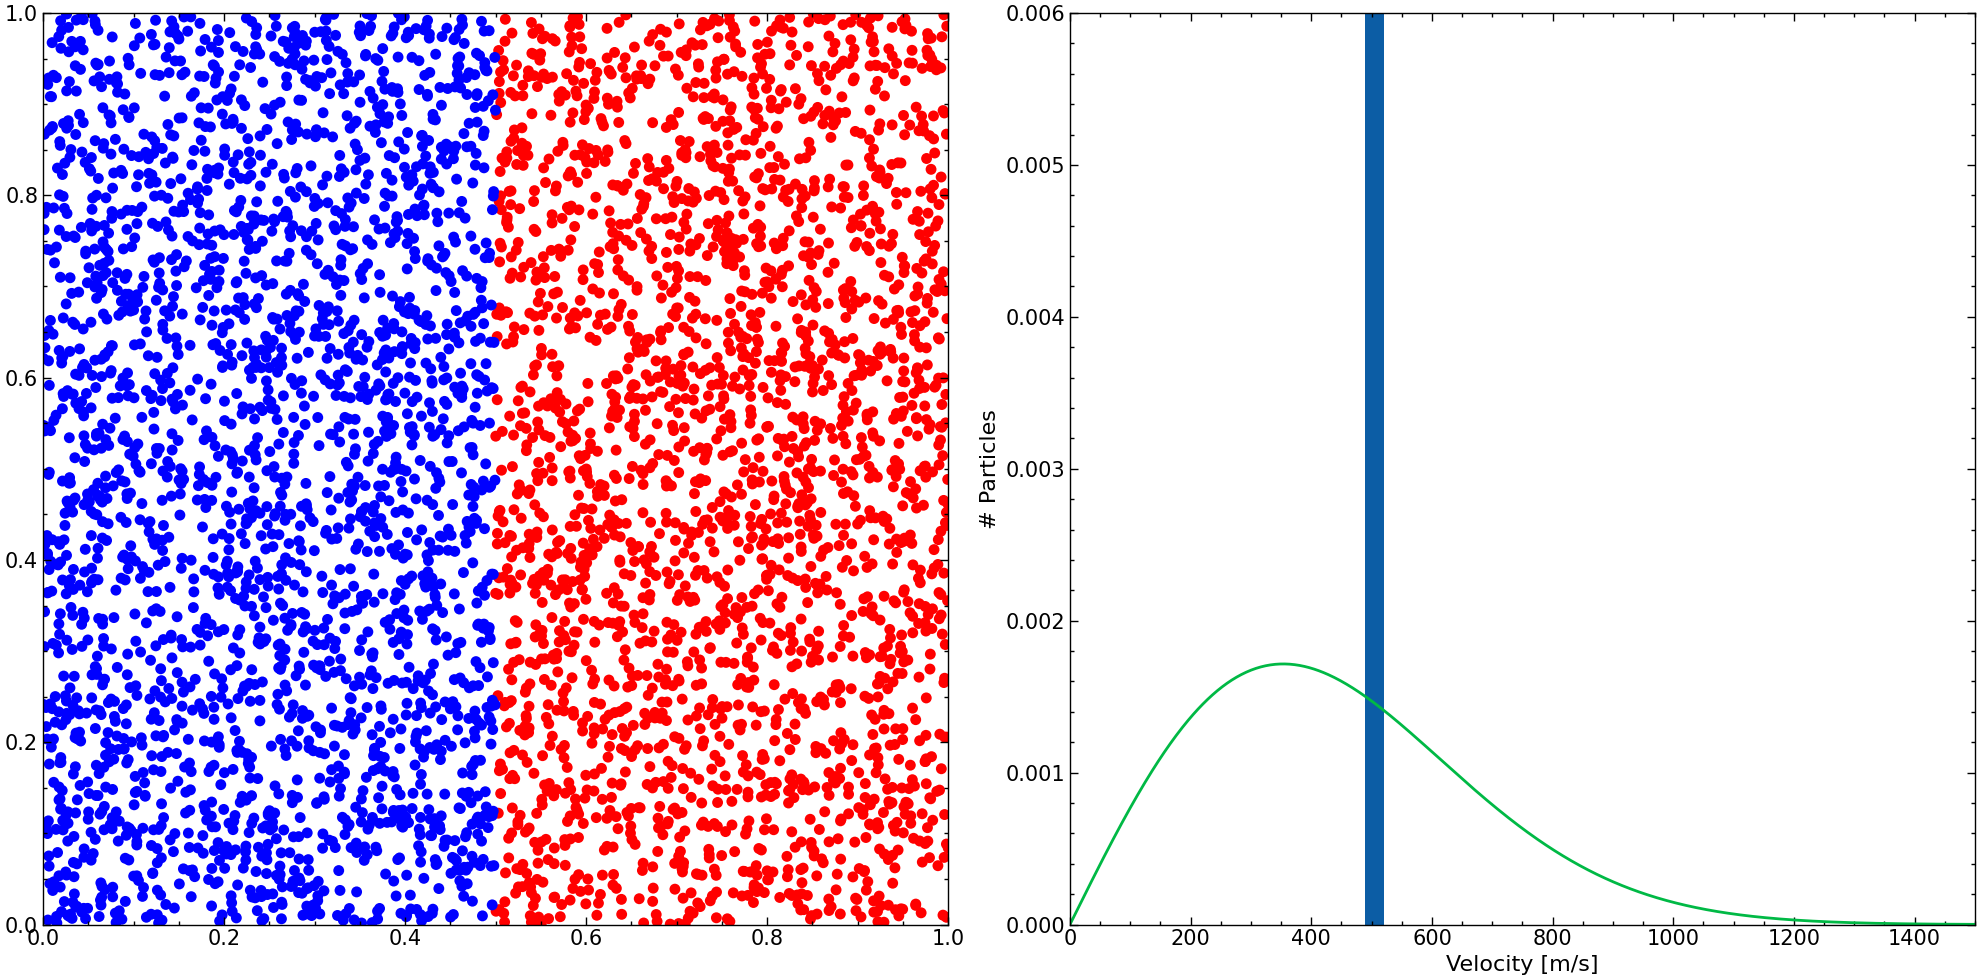

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))


def animate(i):
    [ax.clear() for ax in axes]
    ax = axes[0]
    xred, yred = rs[i][0][ixr], rs[i][1][ixr]
    xblue, yblue = rs[i][0][ixl], rs[i][1][ixl]
    circles_red = [
        plt.Circle((xi, yi), radius=4 * radius, linewidth=0)
        for xi, yi in zip(xred, yred)
    ]
    circles_blue = [
        plt.Circle((xi, yi), radius=4 * radius, linewidth=0)
        for xi, yi in zip(xblue, yblue)
    ]
    cred = matplotlib.collections.PatchCollection(circles_red, facecolors="red")
    cblue = matplotlib.collections.PatchCollection(circles_blue, facecolors="blue")
    ax.add_collection(cred)
    ax.add_collection(cblue)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.tick_params(axis="x", labelsize=15)
    ax.tick_params(axis="y", labelsize=15)
    ax = axes[1]
    ax.hist(np.sqrt(np.sum(vs[i] ** 2, axis=0)), bins=bins, density=True)
    ax.plot(v, fv)
    ax.set_xlabel("Velocity [m/s]")
    ax.set_ylabel("# Particles")
    ax.set_xlim(0, 1500)
    ax.set_ylim(0, 0.006)
    ax.tick_params(axis="x", labelsize=15)
    ax.tick_params(axis="y", labelsize=15)
    fig.tight_layout()


ani = animation.FuncAnimation(fig, animate, frames=500, interval=50)
ani.save("ani.gif", writer="pillow", fps=30, dpi=100)